In [1]:
import torch
assert torch.cuda.is_available(), "A cuda device is required to run this tutorial"

In [2]:
import contextlib

from torch.cuda import Stream


s = Stream()

torch.manual_seed(42)
t1_cpu_pinned = torch.randn(1024**2 * 5, pin_memory=True)
t2_cpu_paged = torch.randn(1024**2 * 5, pin_memory=False)
t3_cuda = torch.randn(1024**2 * 5, device="cuda:0")

assert torch.cuda.is_available()
device = torch.device("cuda", torch.cuda.current_device())


# The function we want to profile
def inner(pinned: bool, streamed: bool):
    with torch.cuda.stream(s) if streamed else contextlib.nullcontext():
        if pinned:
            t1_cuda = t1_cpu_pinned.to(device, non_blocking=True)
        else:
            t2_cuda = t2_cpu_paged.to(device, non_blocking=True)
        t_star_cuda_h2d_event = s.record_event()
    # This operation can be executed during the CPU to GPU copy if and only if the tensor is pinned and the copy is
    #  done in the other stream
    t3_cuda_mul = t3_cuda * t3_cuda * t3_cuda
    t3_cuda_h2d_event = torch.cuda.current_stream().record_event()
    t_star_cuda_h2d_event.synchronize()
    t3_cuda_h2d_event.synchronize()


# Our profiler: profiles the `inner` function and stores the results in a .json file
def benchmark_with_profiler(
    pinned,
    streamed,
) -> None:
    torch._C._profiler._set_cuda_sync_enabled_val(True)
    wait, warmup, active = 1, 1, 2
    num_steps = wait + warmup + active
    rank = 0
    with torch.profiler.profile(
        activities=[
            torch.profiler.ProfilerActivity.CPU,
            torch.profiler.ProfilerActivity.CUDA,
        ],
        schedule=torch.profiler.schedule(
            wait=wait, warmup=warmup, active=active, repeat=1, skip_first=1
        ),
    ) as prof:
        for step_idx in range(1, num_steps + 1):
            inner(streamed=streamed, pinned=pinned)
            if rank is None or rank == 0:
                prof.step()
    prof.export_chrome_trace(f"trace_streamed{int(streamed)}_pinned{int(pinned)}.json")

In [3]:
benchmark_with_profiler(streamed=False, pinned=False)

In [4]:
benchmark_with_profiler(streamed=False, pinned=True)

In [5]:
benchmark_with_profiler(streamed=True, pinned=False)

In [6]:
benchmark_with_profiler(streamed=True, pinned=True)

pageable_tensor.to('cuda:0'):  0.2761 ms
pinned_tensor.to('cuda:0'):  0.1843 ms
pageable_tensor.pin_memory():  0.1615 ms
pageable_tensor.pin_memory().to('cuda:0'):  0.6209 ms


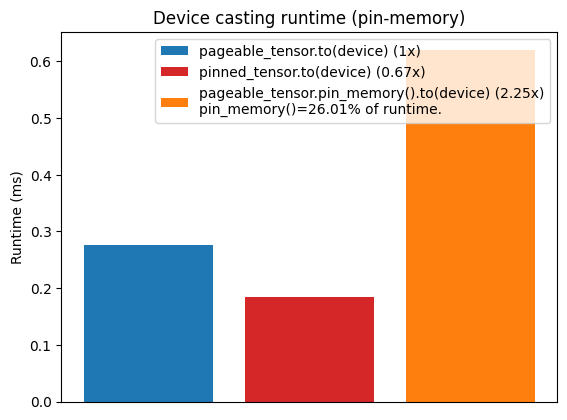

In [7]:
import torch
import gc
from torch.utils.benchmark import Timer
import matplotlib.pyplot as plt


def timer(cmd):
    median = (
        Timer(cmd, globals=globals())
        .adaptive_autorange(min_run_time=1.0, max_run_time=20.0)
        .median
        * 1000
    )
    print(f"{cmd}: {median: 4.4f} ms")
    return median


# A tensor in pageable memory
pageable_tensor = torch.randn(1_000_000)

# A tensor in page-locked (pinned) memory
pinned_tensor = torch.randn(1_000_000, pin_memory=True)

# Runtimes:
pageable_to_device = timer("pageable_tensor.to('cuda:0')")
pinned_to_device = timer("pinned_tensor.to('cuda:0')")
pin_mem = timer("pageable_tensor.pin_memory()")
pin_mem_to_device = timer("pageable_tensor.pin_memory().to('cuda:0')")

# Ratios:
r1 = pinned_to_device / pageable_to_device
r2 = pin_mem_to_device / pageable_to_device

# Create a figure with the results
fig, ax = plt.subplots()

xlabels = [0, 1, 2]
bar_labels = [
    "pageable_tensor.to(device) (1x)",
    f"pinned_tensor.to(device) ({r1:4.2f}x)",
    f"pageable_tensor.pin_memory().to(device) ({r2:4.2f}x)"
    f"\npin_memory()={100*pin_mem/pin_mem_to_device:.2f}% of runtime.",
]
values = [pageable_to_device, pinned_to_device, pin_mem_to_device]
colors = ["tab:blue", "tab:red", "tab:orange"]
ax.bar(xlabels, values, label=bar_labels, color=colors)

ax.set_ylabel("Runtime (ms)")
ax.set_title("Device casting runtime (pin-memory)")
ax.set_xticks([])
ax.legend()

plt.show()

# Clear tensors
del pageable_tensor, pinned_tensor
_ = gc.collect()

copy_to_device(*tensors):  15.2882 ms
copy_to_device_nonblocking(*tensors):  8.4108 ms


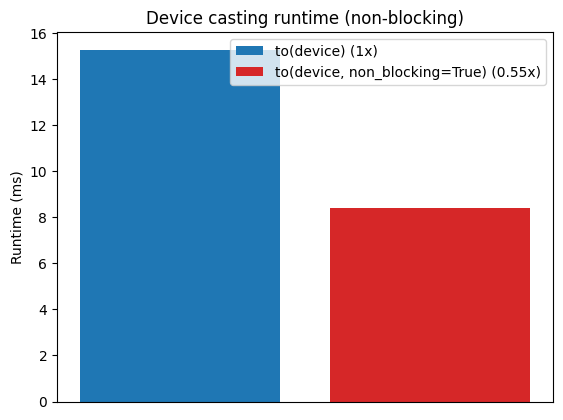

In [8]:
# A simple loop that copies all tensors to cuda
def copy_to_device(*tensors):
    result = []
    for tensor in tensors:
        result.append(tensor.to("cuda:0"))
    return result


# A loop that copies all tensors to cuda asynchronously
def copy_to_device_nonblocking(*tensors):
    result = []
    for tensor in tensors:
        result.append(tensor.to("cuda:0", non_blocking=True))
    # We need to synchronize
    torch.cuda.synchronize()
    return result


# Create a list of tensors
tensors = [torch.randn(1000) for _ in range(1000)]
to_device = timer("copy_to_device(*tensors)")
to_device_nonblocking = timer("copy_to_device_nonblocking(*tensors)")

# Ratio
r1 = to_device_nonblocking / to_device

# Plot the results
fig, ax = plt.subplots()

xlabels = [0, 1]
bar_labels = [f"to(device) (1x)", f"to(device, non_blocking=True) ({r1:4.2f}x)"]
colors = ["tab:blue", "tab:red"]
values = [to_device, to_device_nonblocking]

ax.bar(xlabels, values, label=bar_labels, color=colors)

ax.set_ylabel("Runtime (ms)")
ax.set_title("Device casting runtime (non-blocking)")
ax.set_xticks([])
ax.legend()

plt.show()

In [9]:
from torch.profiler import profile, ProfilerActivity


def profile_mem(cmd):
    with profile(activities=[ProfilerActivity.CPU]) as prof:
        exec(cmd)
    print(cmd)
    print(prof.key_averages().table(row_limit=10))

In [10]:
print("Call to `to(device)`", profile_mem("copy_to_device(*tensors)"))

copy_to_device(*tensors)
-------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                     Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                 aten::to         2.68%     554.841us       100.00%      20.698ms      20.698us          1000  
           aten::_to_copy         8.74%       1.808ms        97.32%      20.143ms      20.143us          1000  
      aten::empty_strided        18.16%       3.759ms        18.16%       3.759ms       3.759us          1000  
              aten::copy_        11.38%       2.356ms        70.42%      14.575ms      14.575us          1000  
          cudaMemcpyAsync        10.96%       2.268ms        10.96%       2.268ms       2.268us          1000  
    cudaStreamSynchronize        48.08%       9.952ms        48.08%       9.952

In [11]:
print(
    "Call to `to(device, non_blocking=True)`",
    profile_mem("copy_to_device_nonblocking(*tensors)"),
)


copy_to_device_nonblocking(*tensors)
-------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                     Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                 aten::to         4.85%     517.084us        99.80%      10.637ms      10.637us          1000  
           aten::_to_copy        15.91%       1.696ms        94.94%      10.120ms      10.120us          1000  
      aten::empty_strided        37.64%       4.012ms        37.64%       4.012ms       4.012us          1000  
              aten::copy_        20.84%       2.221ms        41.40%       4.413ms       4.413us          1000  
          cudaMemcpyAsync        20.56%       2.192ms        20.56%       2.192ms       2.192us          1000  
    cudaDeviceSynchronize         0.20%      21.834us         0.20%

In [12]:
def pin_copy_to_device(*tensors):
    result = []
    for tensor in tensors:
        result.append(tensor.pin_memory().to("cuda:0"))
    return result


def pin_copy_to_device_nonblocking(*tensors):
    result = []
    for tensor in tensors:
        result.append(tensor.pin_memory().to("cuda:0", non_blocking=True))
    # We need to synchronize
    torch.cuda.synchronize()
    return result

copy_to_device(*tensors):  373.0347 ms
copy_to_device_nonblocking(*tensors):  339.9866 ms
copy_to_device(*tensors_pinned):  191.6339 ms
copy_to_device_nonblocking(*tensors_pinned):  169.8050 ms
pin_copy_to_device(*tensors):  644.0817 ms
pin_copy_to_device_nonblocking(*tensors):  489.2297 ms


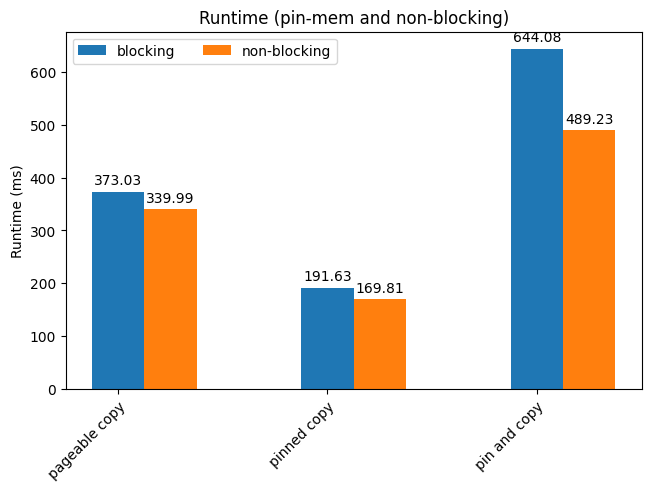

In [13]:
tensors = [torch.randn(1_000_000) for _ in range(1000)]
page_copy = timer("copy_to_device(*tensors)")
page_copy_nb = timer("copy_to_device_nonblocking(*tensors)")

tensors_pinned = [torch.randn(1_000_000, pin_memory=True) for _ in range(1000)]
pinned_copy = timer("copy_to_device(*tensors_pinned)")
pinned_copy_nb = timer("copy_to_device_nonblocking(*tensors_pinned)")

pin_and_copy = timer("pin_copy_to_device(*tensors)")
pin_and_copy_nb = timer("pin_copy_to_device_nonblocking(*tensors)")

# Plot
strategies = ("pageable copy", "pinned copy", "pin and copy")
blocking = {
    "blocking": [page_copy, pinned_copy, pin_and_copy],
    "non-blocking": [page_copy_nb, pinned_copy_nb, pin_and_copy_nb],
}

x = torch.arange(3)
width = 0.25
multiplier = 0


fig, ax = plt.subplots(layout="constrained")

for attribute, runtimes in blocking.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, runtimes, width, label=attribute)
    ax.bar_label(rects, padding=3, fmt="%.2f")
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Runtime (ms)")
ax.set_title("Runtime (pin-mem and non-blocking)")
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(strategies)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.legend(loc="upper left", ncols=3)

plt.show()

del tensors, tensors_pinned
_ = gc.collect()

In [14]:
tensor = (
    torch.arange(1, 1_000_000, dtype=torch.double, device="cuda")
    .expand(100, 999999)
    .clone()
)
torch.testing.assert_close(
    tensor.mean(), torch.tensor(500_000, dtype=torch.double, device="cuda")
), tensor.mean()
try:
    i = -1
    for i in range(100):
        cpu_tensor = tensor.to("cpu", non_blocking=True)
        torch.testing.assert_close(
            cpu_tensor.mean(), torch.tensor(500_000, dtype=torch.double)
        )
    print("No test failed with non_blocking")
except AssertionError:
    print(f"{i}th test failed with non_blocking. Skipping remaining tests")
try:
    i = -1
    for i in range(100):
        cpu_tensor = tensor.to("cpu", non_blocking=True)
        torch.cuda.synchronize()
        torch.testing.assert_close(
            cpu_tensor.mean(), torch.tensor(500_000, dtype=torch.double)
        )
    print("No test failed with synchronize")
except AssertionError:
    print(f"One test failed with synchronize: {i}th assertion!")

0th test failed with non_blocking. Skipping remaining tests
No test failed with synchronize


td.to('cuda:0', non_blocking=False):  371.8794 ms
td.to('cuda:0'):  333.8725 ms
td.to('cuda:0', non_blocking_pin=True, num_threads=0):  493.7997 ms
td.to('cuda:0', non_blocking_pin=True, num_threads=4):  420.1258 ms


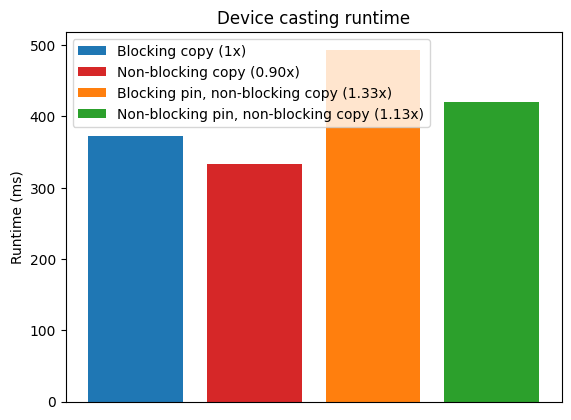

In [15]:
from tensordict import TensorDict
import torch
from torch.utils.benchmark import Timer
import matplotlib.pyplot as plt

# Create the dataset
td = TensorDict({str(i): torch.randn(1_000_000) for i in range(1000)})

# Runtimes
copy_blocking = timer("td.to('cuda:0', non_blocking=False)")
copy_non_blocking = timer("td.to('cuda:0')")
copy_pin_nb = timer("td.to('cuda:0', non_blocking_pin=True, num_threads=0)")
copy_pin_multithread_nb = timer("td.to('cuda:0', non_blocking_pin=True, num_threads=4)")

# Rations
r1 = copy_non_blocking / copy_blocking
r2 = copy_pin_nb / copy_blocking
r3 = copy_pin_multithread_nb / copy_blocking

# Figure
fig, ax = plt.subplots()

xlabels = [0, 1, 2, 3]
bar_labels = [
    "Blocking copy (1x)",
    f"Non-blocking copy ({r1:4.2f}x)",
    f"Blocking pin, non-blocking copy ({r2:4.2f}x)",
    f"Non-blocking pin, non-blocking copy ({r3:4.2f}x)",
]
values = [copy_blocking, copy_non_blocking, copy_pin_nb, copy_pin_multithread_nb]
colors = ["tab:blue", "tab:red", "tab:orange", "tab:green"]

ax.bar(xlabels, values, label=bar_labels, color=colors)

ax.set_ylabel("Runtime (ms)")
ax.set_title("Device casting runtime")
ax.set_xticks([])
ax.legend()

plt.show()